<a href="https://colab.research.google.com/github/hiydavid/homl-learning/blob/main/projects/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured Data Classification From Scratch
## Cleveland Clinic Foundation for Heart Disease

* Convert pandas dataframe object to a tensorflow dataset object
* Preprocess dataset through normalization and encoding
* Define model
* Train model
* Predict a sample

---
# Setup

In [1]:
# load libaries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# get data
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [3]:
# check df
dataframe.shape

(303, 14)

In [4]:
# check few rows
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


---
# Preprocess data

In [5]:
# get training & validation sets
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


In [6]:
# turn pandas dataframe to tf.dataset
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [7]:
# check input / output of dataset
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=35>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=198>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=130>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.6>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [8]:
# set batch of 32
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

---
# Feature preprocessing with Keras layers

In [9]:
# load libaries
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

In [10]:
# apply featurewise normalization to numerical features
def encode_numerical_feature(feature, name, dataset):

    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    
    return encoded_feature

In [11]:
# first turn string inputs into integer indices
# then one-hot encode these integer indices
def encode_categorical_feature(feature, name, dataset, is_string):

    lookup_class = StringLookup if is_string else IntegerLookup
    
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    
    return encoded_feature

---
# Build a model

In [18]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

In [19]:
# create list of inputs
all_inputs = [
    sex, cp, fbs, restecg, exang, ca, thal, age, 
    trestbps, chol, thalach, oldpeak, slope,
]

In [20]:
# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

In [21]:
# list of all features
all_features = layers.concatenate(
    [sex_encoded, cp_encoded, fbs_encoded, restecg_encoded, exang_encoded,
     slope_encoded, ca_encoded, thal_encoded, age_encoded, trestbps_encoded,
     chol_encoded, thalach_encoded, oldpeak_encoded,
    ]
)

In [23]:
# build model
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sex (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
cp (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
fbs (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
restecg (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

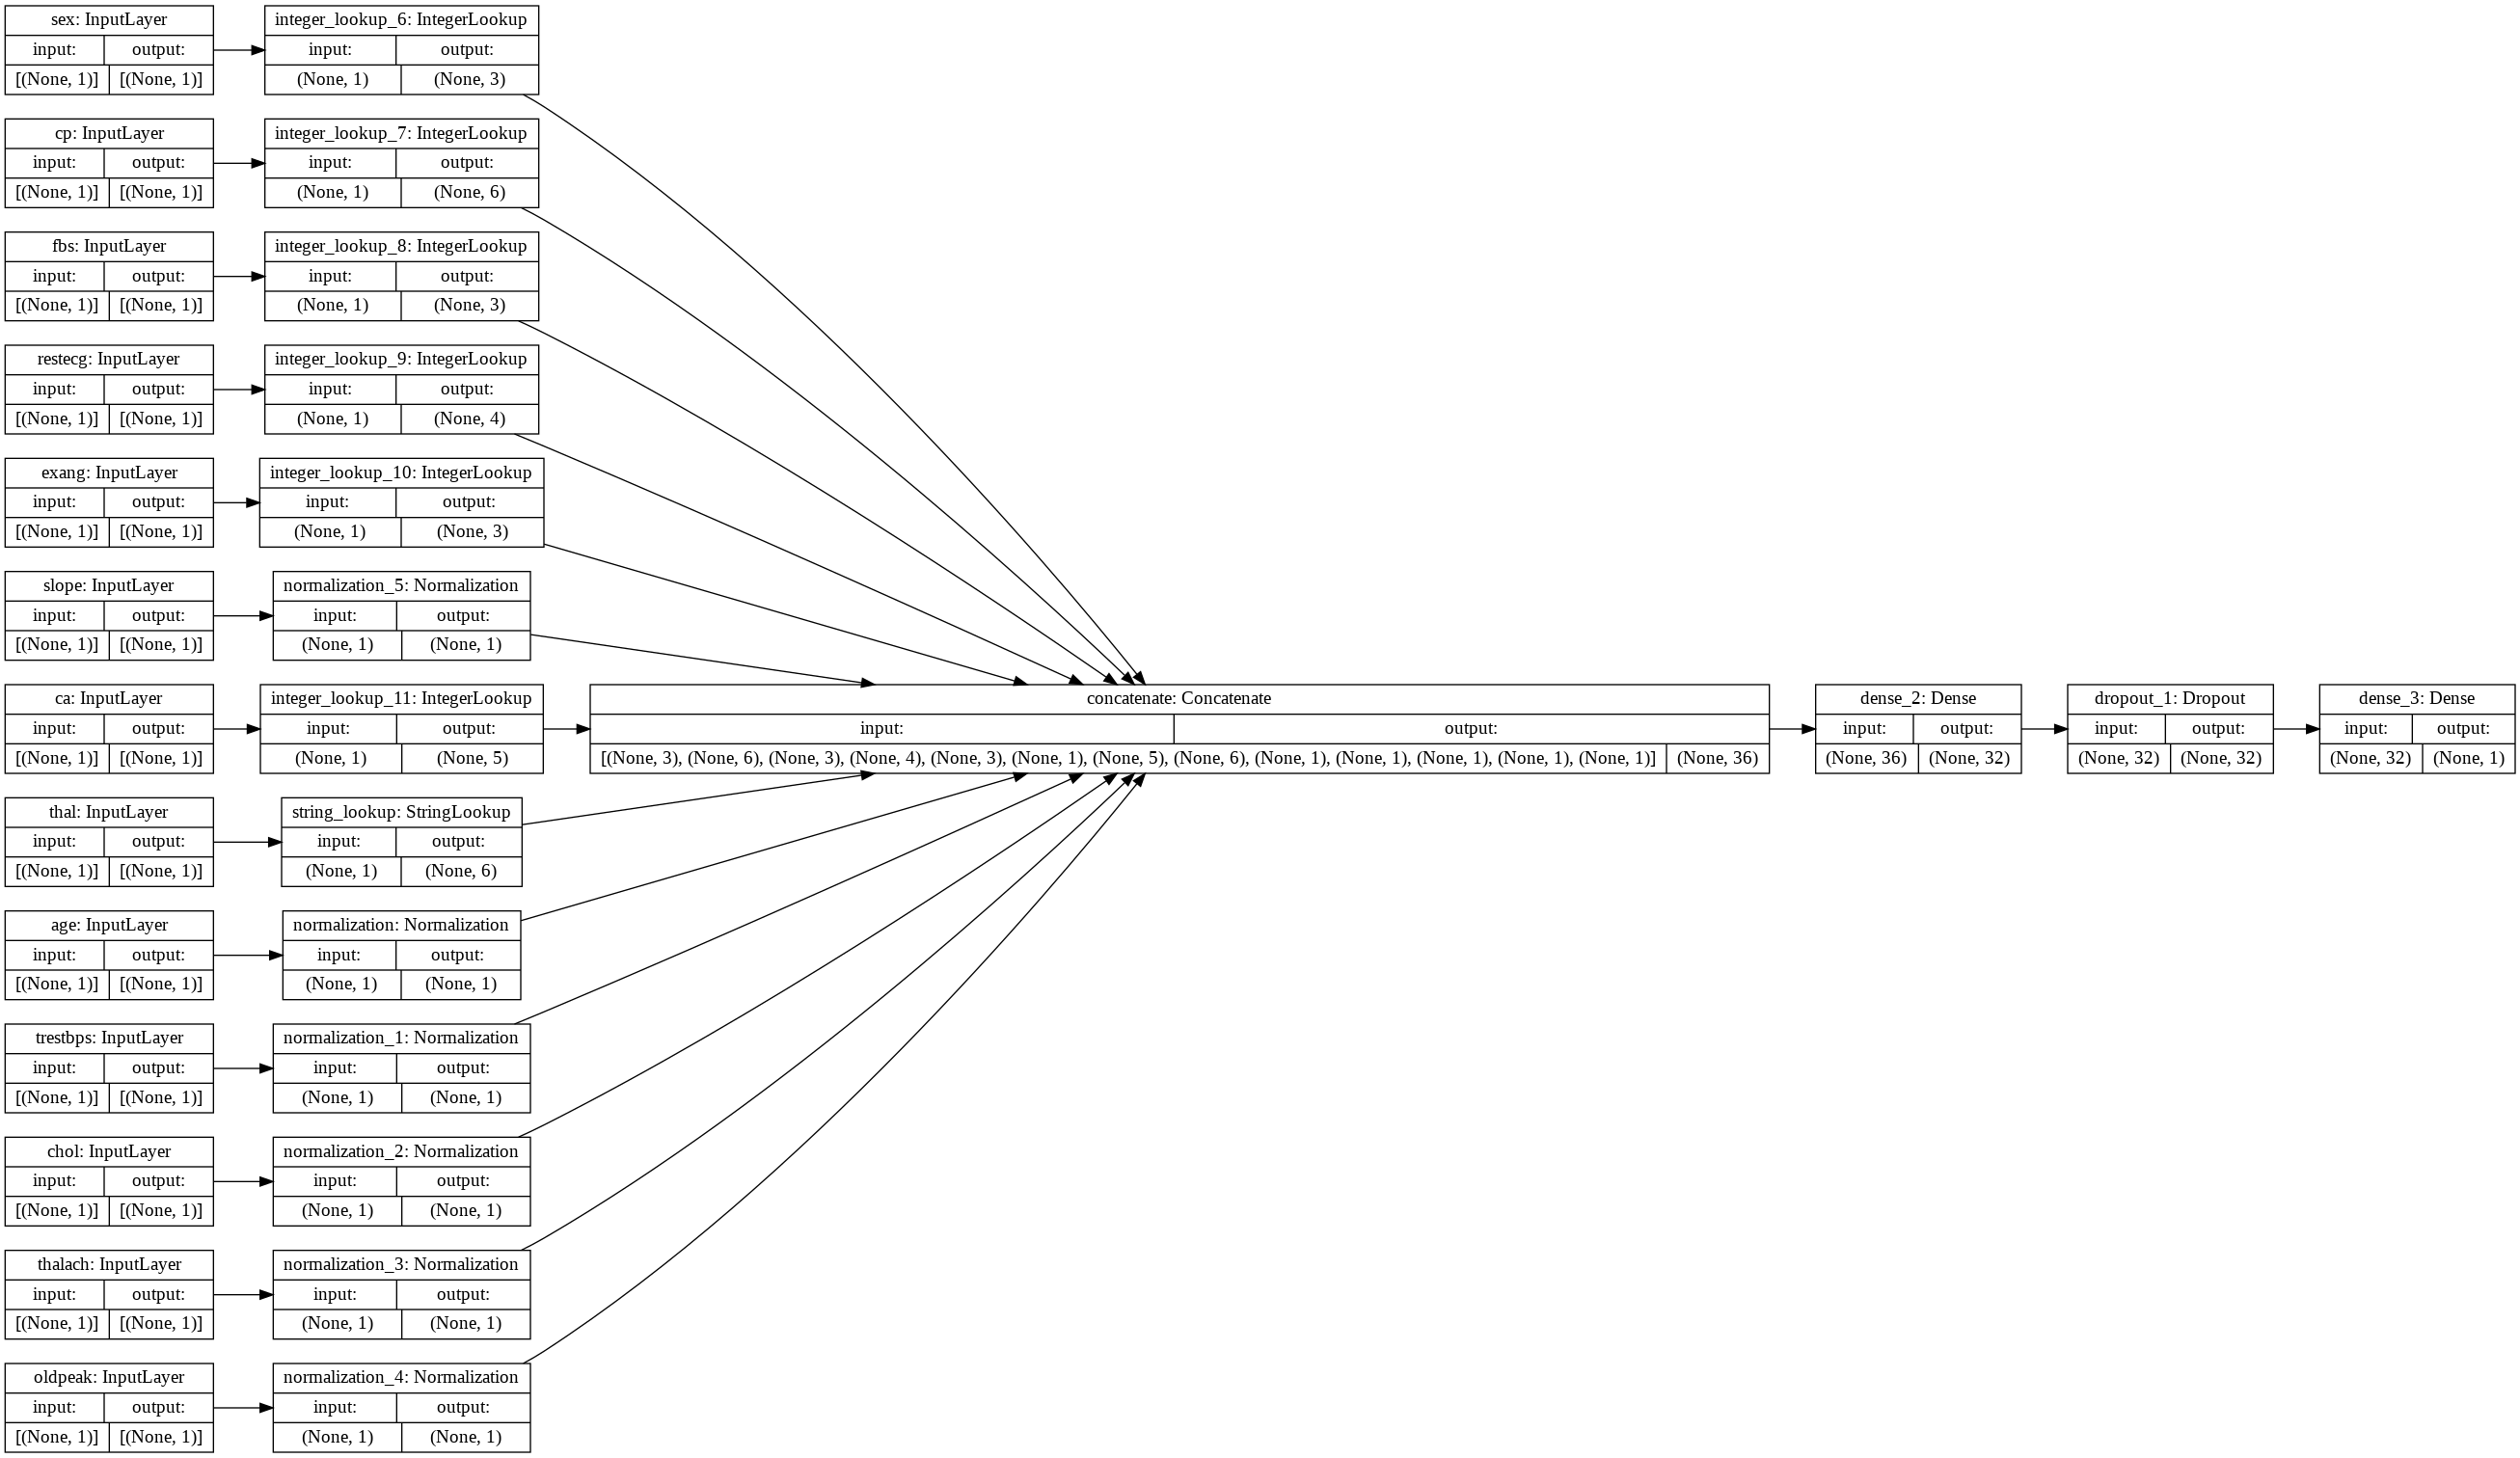

In [24]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

---
# Train the model

In [25]:
# fit
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 4s 62ms/step - loss: 0.6266 - accuracy: 0.6446 - val_loss: 0.5857 - val_accuracy: 0.6721
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.6292 - accuracy: 0.6653 - val_loss: 0.5428 - val_accuracy: 0.7049
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5793 - accuracy: 0.7273 - val_loss: 0.5093 - val_accuracy: 0.7377
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5340 - accuracy: 0.7438 - val_loss: 0.4848 - val_accuracy: 0.7869
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.5219 - accuracy: 0.7851 - val_loss: 0.4653 - val_accuracy: 0.7869
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 0.5126 - accuracy: 0.7521 - val_loss: 0.4509 - val_accuracy: 0.8033
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.4866 - accuracy: 0.7727 - val_loss: 0.4403 - val_accuracy: 0.8197
Epoch 8/50
8/8 [===========

---
# Inference on new data

In [27]:
# predict sample
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {
    name: tf.convert_to_tensor([value]) 
    for name, value 
    in sample.items()
}

input_dict

{'age': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([60], dtype=int32)>,
 'ca': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'chol': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([233], dtype=int32)>,
 'cp': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'exang': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'fbs': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'oldpeak': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.3], dtype=float32)>,
 'restecg': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 'sex': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'slope': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>,
 'thal': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'fixed'], dtype=object)>,
 'thalach': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([150], dtype=int32)>,
 'trestbps': <tf.Tensor: shape=(1,), dty

In [28]:
# predict
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 23.8 percent probability of having a heart disease, as evaluated by our model.
